# **PROBLEM 1**

#### Task 1: Preprocessing the Time-Series Data
* Load the dataset
* Segment the time series into overlapping windows
* Compute pairwise distances (DTW & Euclidean)
* Construct similarity matrix

In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Loaded dataset with shape: (7352, 561)
Segmented time series shape: (113, 128, 561)
Sample segment labels: (array([1, 2, 4, 5, 6]), array([24,  6, 11, 37, 35]))
Computed DTW distance matrix shape: (113, 113)
Computed Euclidean distance matrix shape: (113, 113)
Number of NaN values in DTW distance matrix: 0
Number of non-diagonal zeros in DTW distance matrix: 0
Computed sigma value for similarity matrix: 0.7510833490725068
Computed sigma value for similarity matrix: 26.41490104190216
Computed similarity matrix dtw shape: (113, 113)
Computed similarity matrix euclidean shape: (113, 113)


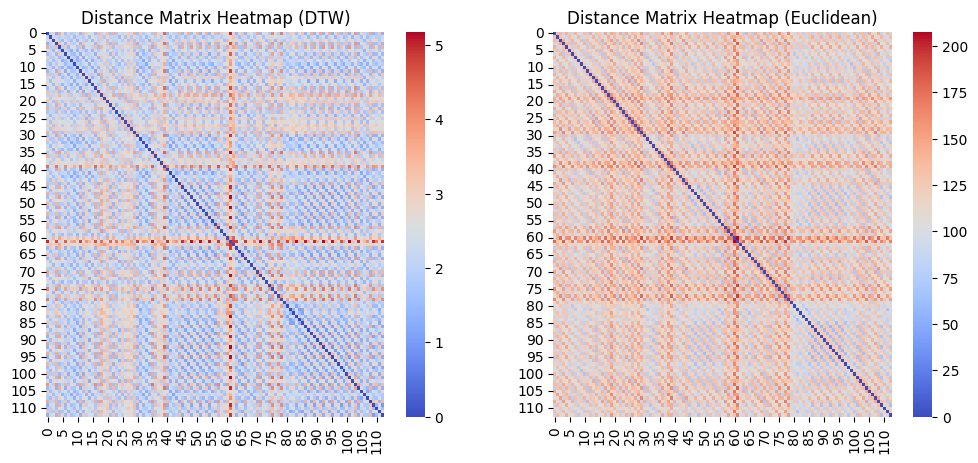

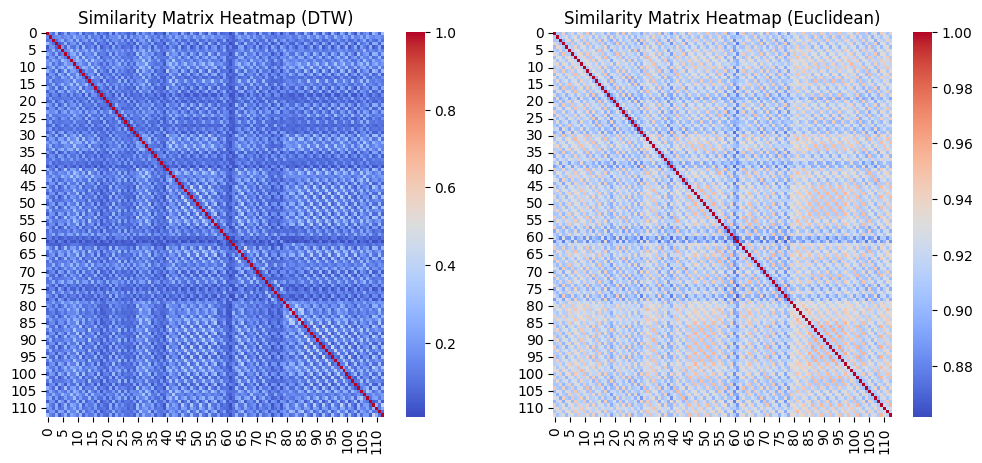

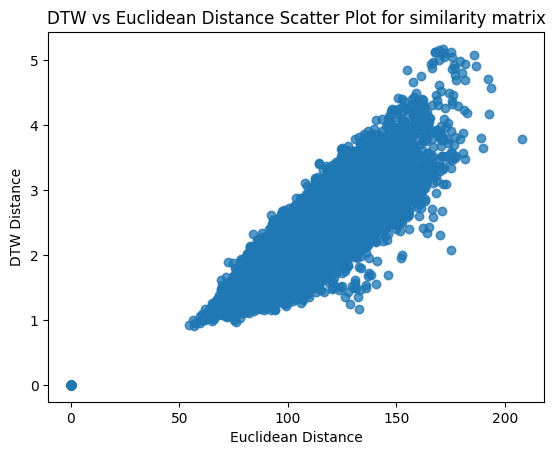

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
!pip install dtaidistance
from dtaidistance import dtw
from dtaidistance.dtw import distance_matrix_fast

# Load the HAR dataset
def load_har_dataset(sample_size=None):
    data = pd.read_csv("/content/drive/My Drive/xtrain", sep='\\s+', header=None)
    labels = pd.read_csv("/content/drive/My Drive/ytrain", header=None).values.ravel()
    if sample_size:
        data = data.iloc[:sample_size]
        labels = labels[:sample_size]

    return data, labels

# Segment the dataset
def segment_time_series(data, labels, window_size=128, step=64):
    segments, segment_labels = [], []
    for start in range(0, len(data) - window_size, step):
        segment = data.iloc[start:start + window_size].values
        segments.append(segment)
        segment_labels.append(np.bincount(labels[start:start + window_size]).argmax())  # Majority label
    return np.array(segments), np.array(segment_labels)

# Compute DTW distance matrix feature-wise and average
def compute_multivariate_dtw_distance(segments):
    num_segments, window_size, num_features = segments.shape
    distance_matrix = np.zeros((num_segments, num_segments))

    for feature in range(num_features):
        feature_segments = segments[:, :, feature]
        dtw_dist = distance_matrix_fast(feature_segments)
        dtw_dist = np.nan_to_num(dtw_dist)
        distance_matrix += dtw_dist

    distance_matrix /= num_features
    return distance_matrix

# Compute Euclidean distance matrix
def compute_euclidean_distance_matrix(segments):
    reshaped_segments = segments.reshape(segments.shape[0], -1)
    return pairwise_distances(reshaped_segments, metric='euclidean')

# Compute similarity matrix
def compute_similarity_matrix(distance_matrix):
    sigma = np.std(distance_matrix) + 1e-8
    print(f"Computed sigma value for similarity matrix: {sigma}")
    similarity_matrix = np.exp(-distance_matrix / (2 * sigma ** 2))
    return similarity_matrix

# Load dataset (Testing with a smaller subset first)
data, labels = load_har_dataset()
print(f"Loaded dataset with shape: {data.shape}")

# Segment data
segments, segment_labels = segment_time_series(data, labels)
print(f"Segmented time series shape: {segments.shape}")
print(f"Sample segment labels: {np.unique(segment_labels, return_counts=True)}")


# Compute DTW and Euclidean distance matrices
distance_matrix_dtw = compute_multivariate_dtw_distance(segments)
distance_matrix_euclidean = compute_euclidean_distance_matrix(segments)
print(f"Computed DTW distance matrix shape: {distance_matrix_dtw.shape}")
print(f"Computed Euclidean distance matrix shape: {distance_matrix_euclidean.shape}")

# Check for NaNs in the distance matrix
num_nans = np.isnan(distance_matrix_dtw).sum()
print(f"Number of NaN values in DTW distance matrix: {num_nans}")

# Check for non-diagonal zeros in the DTW distance matrix
num_zeros = np.sum((distance_matrix_dtw == 0) & ~np.eye(distance_matrix_dtw.shape[0], dtype=bool))
print(f"Number of non-diagonal zeros in DTW distance matrix: {num_zeros}")

# Compute similarity matrix
similarity_matrix_dtw = compute_similarity_matrix(distance_matrix_dtw)
similarity_matrix_euclidean = compute_similarity_matrix(distance_matrix_euclidean)

print(f"Computed similarity matrix dtw shape: {similarity_matrix_dtw.shape}")
print(f"Computed similarity matrix euclidean shape: {similarity_matrix_euclidean.shape}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(distance_matrix_dtw, cmap='coolwarm', annot=False, ax=axes[0])
axes[0].set_title("Distance Matrix Heatmap (DTW)")

sns.heatmap(distance_matrix_euclidean, cmap='coolwarm', annot=False, ax=axes[1])
axes[1].set_title("Distance Matrix Heatmap (Euclidean)")
plt.show()


# Visualize similarity matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(similarity_matrix_dtw, cmap='coolwarm', annot=False, ax=axes[0])
axes[0].set_title("Similarity Matrix Heatmap (DTW)")

sns.heatmap(similarity_matrix_euclidean, cmap='coolwarm', annot=False, ax=axes[1])
axes[1].set_title("Similarity Matrix Heatmap (Euclidean)")
plt.show()

# Plot distribution of DTW vs Euclidean distances
euclidean_matrix = pairwise_distances(segments.reshape(segments.shape[0], -1), metric='euclidean')


plt.scatter(euclidean_matrix.flatten(), distance_matrix_dtw.flatten(), alpha=0.5)
plt.xlabel("Euclidean Distance")
plt.ylabel("DTW Distance")
plt.title("DTW vs Euclidean Distance Scatter Plot for similarity matrix")
plt.show()

####Task 2: Apply Diffusion Maps for Dimensionality Reduction
* Construct Diffusion Kernel
* Compute Normalized Graph Laplacian
* Compute leading eigenvectors
* Embed into a low-dimensional space

Using epsilon: 2.36422869898574
Top 10 Eigenvalues: [5.15148498e-17 2.80522420e-01 4.72940017e-01 5.04826235e-01]
Diffusion map embedding shape: (113, 3)
Diffusion Map Embedding (First 5 rows):
[[ 0.12150606 -0.06764081 -0.02492083]
 [ 0.0016179   0.09761345 -0.02688665]
 [-0.07412315 -0.08095337  0.08407512]
 [ 0.11963861 -0.04132538 -0.03631609]
 [-0.12348553  0.00691064  0.0075639 ]]


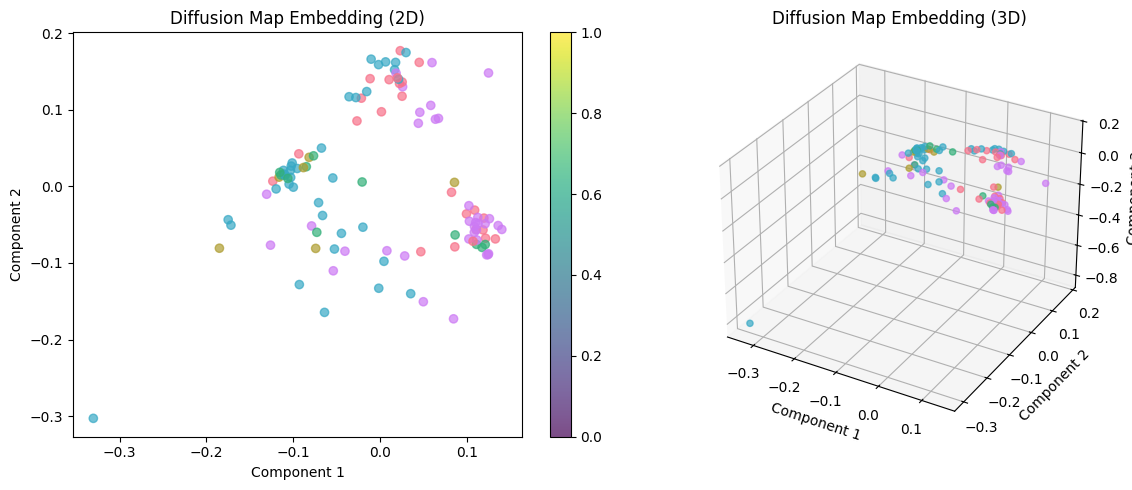

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse.linalg import eigsh

# Construct Diffusion Kernel with Auto-tuned ε
def diffusion_kernel(distance_matrix, epsilon=None):

    distance_matrix = np.array(distance_matrix)
    np.fill_diagonal(distance_matrix, 1e-6)


    if epsilon is None:
        eps_values = [
            np.median(distance_matrix[distance_matrix > 0]),
            np.mean(distance_matrix[distance_matrix > 0]),
            np.percentile(distance_matrix[distance_matrix > 0], 75),np.percentile(distance_matrix[distance_matrix > 0], 50)

        ]
        epsilon = eps_values[0]

    print(f"Using epsilon: {epsilon}")

    K = np.exp(-distance_matrix ** 2 / epsilon)

    # Normalize using Degree Matrix
    D = np.diag(K.sum(axis=1))
    K = np.linalg.inv(D) @ K @ np.linalg.inv(D)
    return K



# Compute normalized graph Laplacian & eigenvectors
def diffusion_maps(distance_matrix, epsilon=None, n_components=3):
    K = diffusion_kernel(distance_matrix, epsilon)

    # Compute Laplacian
    D = np.diag(K.sum(axis=1))
    D_sqrt_inv = np.linalg.inv(np.sqrt(D))
    L = np.eye(K.shape[0]) - D_sqrt_inv @ K @ D_sqrt_inv

    # Eigen decomposition (Use sparse solver for efficiency)
    eigenvalues, eigenvectors = eigsh(L, k=n_components+1, which='SM')

    # Sort eigenvalues in ascending order
    idx = np.argsort(eigenvalues)
    eigenvalues, eigenvectors = eigenvalues[idx], eigenvectors[:, idx]

    print("Top 10 Eigenvalues:", eigenvalues[:10])

    return eigenvectors[:, 1:n_components+1]


# Apply Diffusion Maps
embedding = diffusion_maps(distance_matrix_dtw)
print(f"Diffusion map embedding shape: {embedding.shape}")
print("Diffusion Map Embedding (First 5 rows):")
print(embedding[:5])


# Improved Color Mapping
activity_labels = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Lying Down']
num_labels = len(activity_labels)

# Improved Color Mapping
import seaborn as sns

unique_labels = sorted(set(segment_labels))
num_labels = len(set(segment_labels))

# Generate distinct colors
colors = sns.color_palette("husl", num_labels)
label_to_color = {label: color for label, color in zip(unique_labels, colors)}

# Map each segment label to its corresponding color
point_colors = [label_to_color[label] for label in segment_labels]


# Visualization
fig = plt.figure(figsize=(12, 5))

# 2D Diffusion Map Embedding
ax1 = fig.add_subplot(1, 2, 1)
scatter = ax1.scatter(embedding[:, 0], embedding[:, 1], c=point_colors, alpha=0.7)
ax1.set_title("Diffusion Map Embedding (2D)")
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")
fig.colorbar(scatter, ax=ax1)

# 3D Diffusion Map Embedding
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=point_colors, alpha=0.7)
ax2.set_title("Diffusion Map Embedding (3D)")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")
ax2.set_zlabel("Component 3")

plt.tight_layout()
plt.show()

#### Task 3: Clustering in the Diffusion Space
* Apply K-Means or DBSCAN
* Evaluate clustering performance (ARI, Silhouette Score)
* Visualize clustering results

Elbow method for optimal k in K means

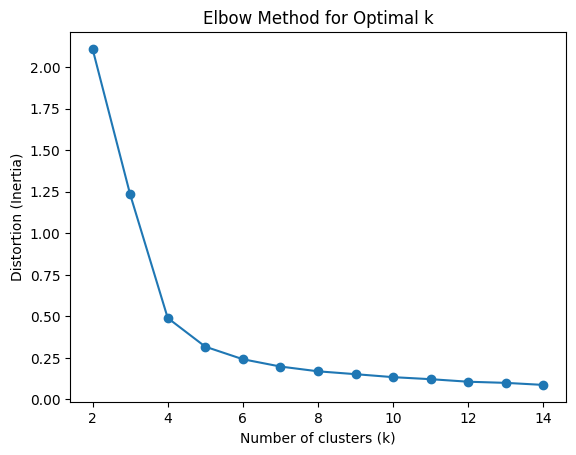

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
import numpy as np
import matplotlib.pyplot as plt



distortions = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embedding)
    distortions.append(kmeans.inertia_)

plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()


K-Means - Adjusted Rand Index (ARI): 0.1126
K-Means - Silhouette Score: 0.6162


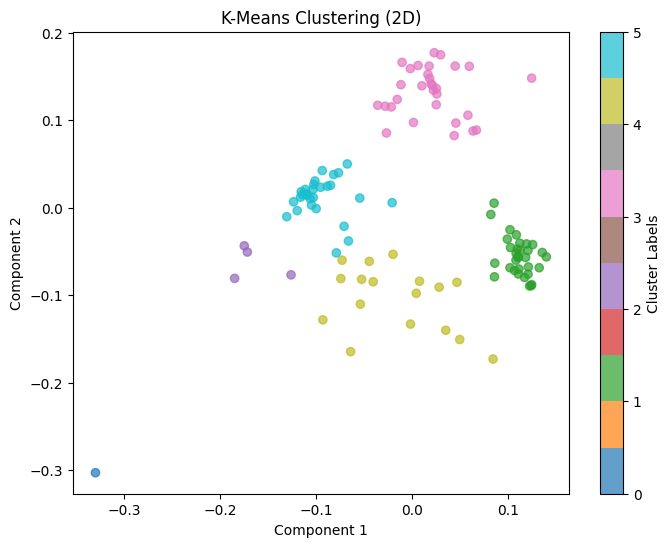

In [ ]:
best_k = 6  # Pick from elbow method
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
predicted_labels_kmeans = kmeans.fit_predict(embedding)

ari_kmeans = adjusted_rand_score(segment_labels, predicted_labels_kmeans)
silhouette_kmeans = silhouette_score(embedding, predicted_labels_kmeans)

print(f"K-Means - Adjusted Rand Index (ARI): {ari_kmeans:.4f}")
print(f"K-Means - Silhouette Score: {silhouette_kmeans:.4f}")

def plot_clusters(embedding, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(label="Cluster Labels")
    plt.show()

plot_clusters(embedding, predicted_labels_kmeans, "K-Means Clustering (2D)")


Finding optimal eps using elbow method for DBSCAN

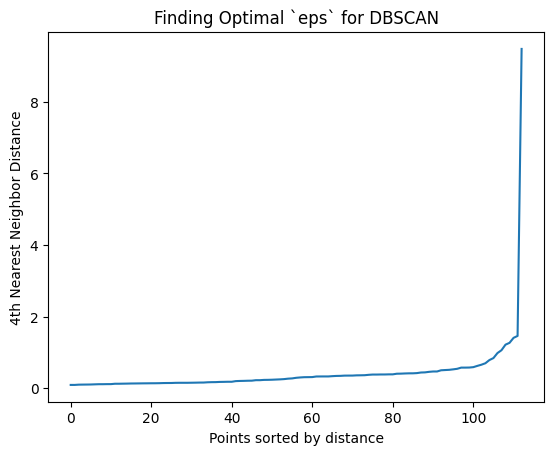

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score
import numpy as np
import matplotlib.pyplot as plt


embedding = StandardScaler().fit_transform(embedding)

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(embedding)
distances, indices = neighbors_fit.kneighbors(embedding)
distances = np.sort(distances[:, 4], axis=0)

plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.title("Finding Optimal `eps` for DBSCAN")
plt.show()




Number of noise points: 9
DBSCAN - Adjusted Rand Index (ARI): 0.1340
DBSCAN - Silhouette Score: 0.5656


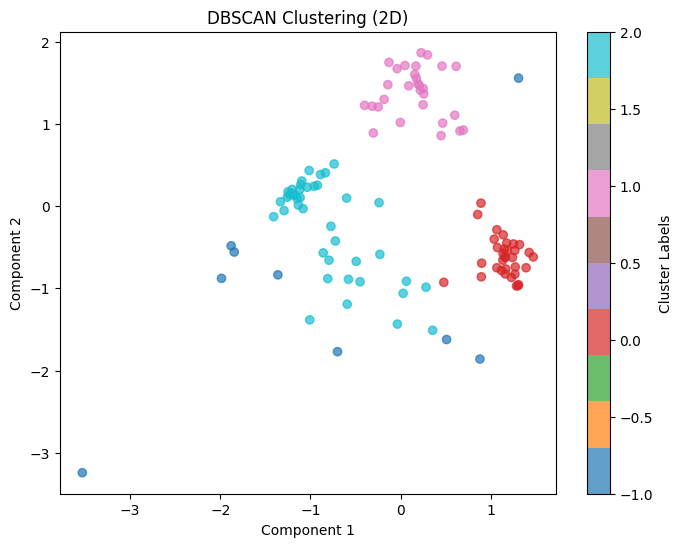

In [ ]:

best_eps = 0.6
dbscan = DBSCAN(eps=best_eps, min_samples=8)
predicted_labels_dbscan = dbscan.fit_predict(embedding)

num_noise = np.sum(predicted_labels_dbscan == -1)
print(f"Number of noise points: {num_noise}")

ari_dbscan = adjusted_rand_score(segment_labels, predicted_labels_dbscan)


silhouette_dbscan = silhouette_score(embedding, predicted_labels_dbscan) if len(set(predicted_labels_dbscan)) > 1 else 0

print(f"DBSCAN - Adjusted Rand Index (ARI): {ari_dbscan:.4f}")
print(f"DBSCAN - Silhouette Score: {silhouette_dbscan:.4f}")


def plot_clusters(embedding, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(label="Cluster Labels")
    plt.show()

plot_clusters(embedding, predicted_labels_dbscan, "DBSCAN Clustering (2D)")

#### Task 4: Visualization and Interpretation
* Scatter Plot the Diffusion Embeddings
* Compare Clustering Quality
(Raw feature space,
Principal Component Analysis (PCA),
t-Distributed Stochastic Neighbor Embedding (t-SNE),
Diffusion Maps)
* Discussion on Diffusion Maps

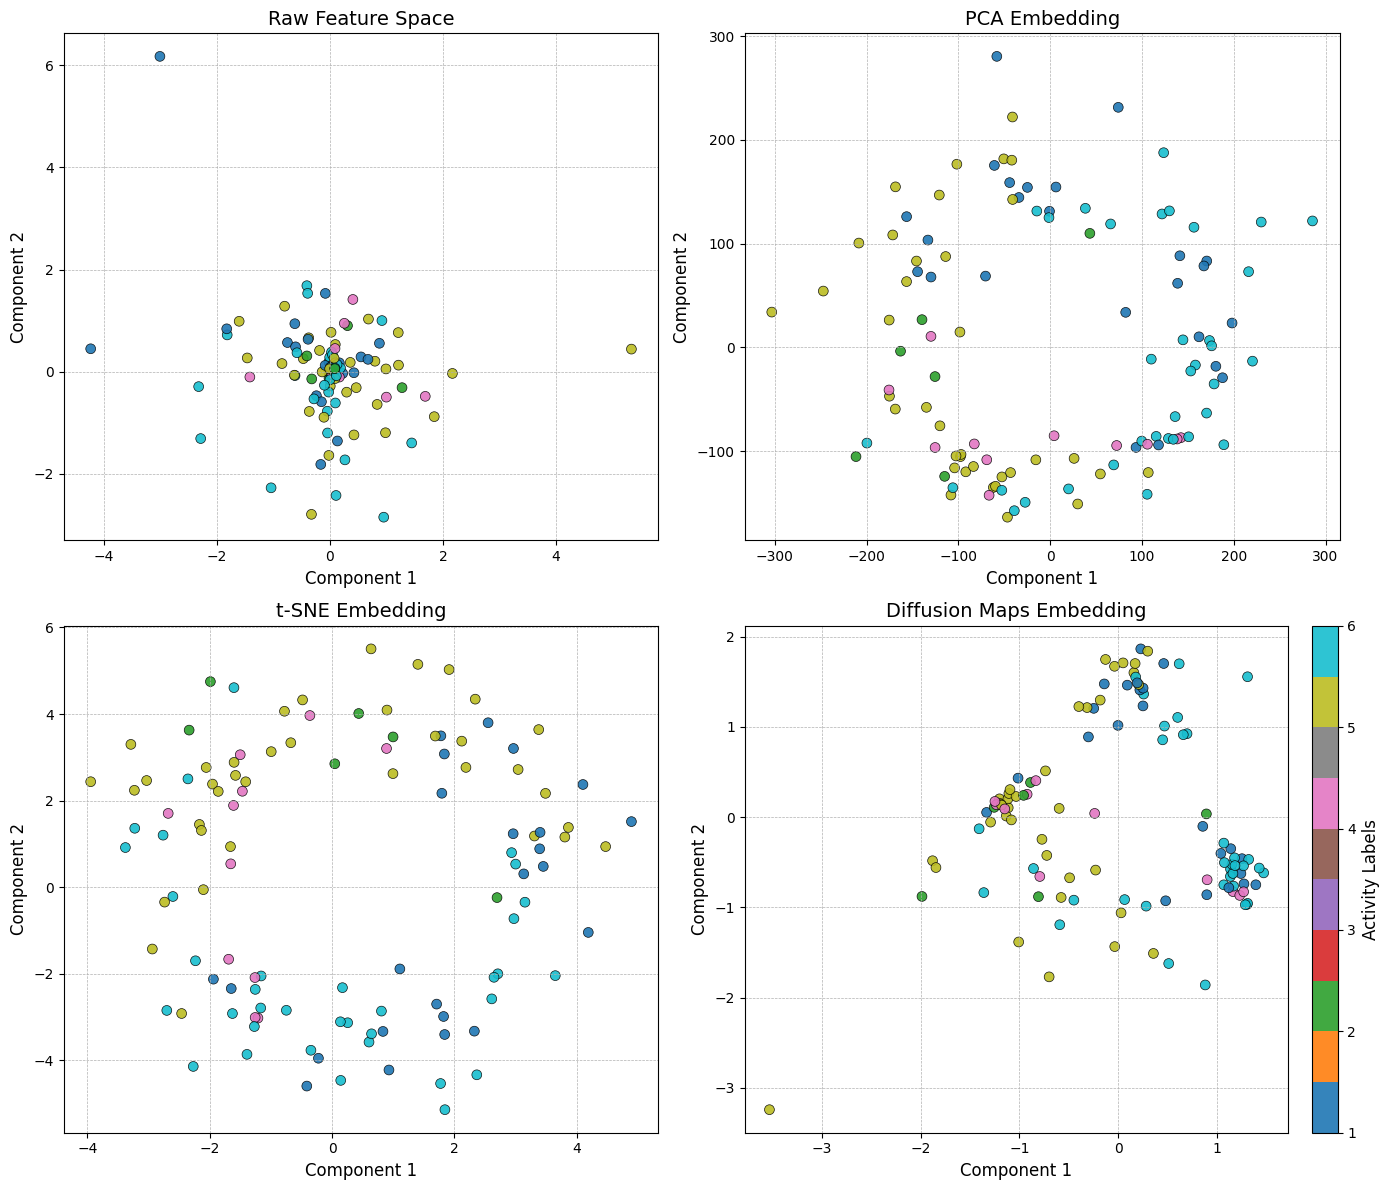

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Standardize the data for better visualization
scaler = StandardScaler()
segments_scaled = scaler.fit_transform(segments.reshape(len(segments), -1))

# Apply PCA
pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(segments_scaled)

# Apply t-SNE with adjusted perplexity
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
embedding_tsne = tsne.fit_transform(segments_scaled)

# Function to visualize embeddings with larger, clearer dots
def plot_embedding(ax, embedding, labels, title):
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', alpha=0.9, s=50, edgecolors='black', linewidth=0.5)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Component 1", fontsize=12)
    ax.set_ylabel("Component 2", fontsize=12)
    ax.grid(True, linestyle="--", linewidth=0.5)

    # Add colorbar only to the last subplot
    if title == "Diffusion Maps Embedding":
        cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("Activity Labels", fontsize=12)

# Plot all embeddings in a single figure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

plot_embedding(axes[0, 0], segments_scaled[:, :2], segment_labels, "Raw Feature Space")
plot_embedding(axes[0, 1], embedding_pca, segment_labels, "PCA Embedding")
plot_embedding(axes[1, 0], embedding_tsne, segment_labels, "t-SNE Embedding")
plot_embedding(axes[1, 1], embedding[:, :2], segment_labels, "Diffusion Maps Embedding")

plt.tight_layout()
plt.show()
